In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

## Stochastic Setup

Let us specify the transition rates:
$$\begin{aligned}
\mathbb{P}(S \rightarrow E) &= \beta SI/N\\
\mathbb{P}(E \rightarrow I) &= \gamma E\\
\mathbb{P}(I \rightarrow R) &= \alpha I\\
\end{aligned}$$

These transition rates are then used in the CTMC forumlation.

In [2]:
def det_model(state, p):
    b, g, a = p
    s, e, i, r = state
    n = sum(state)
    return [
        -b*s*i/n,
        b*s*i/n - g*e,
        g*e - a*i,
        a*i
    ]

def transition(state, p):
    b, g, a = p
    s, e, i, r = state
    n = sum(state)
    update = copy.copy(state)
    # time to next event
    bins = np.array([b*s*i/n, g*e, a*i])
    sbins = np.linalg.norm(bins, ord=1)
    dt = np.random.exponential(1/sbins)
    # draw type of event and propagate
    bins /= sbins
    seed = np.random.uniform()
    x = np.digitize(seed, np.cumsum(bins))
    x = max(min(x, 2), 0)
    update[x] -= 1
    update[x+1] += 1
    return dt, update

In [3]:
y0 = [100, 0, 1, 0]
p0 = [5, 0.1, 0.1]
    
def realise(y0, p):
    history = {'t': [], 'y':[]}
    t = 0
    y = y0

    T = 10000
    while t < T:
        history['t'].append(t)
        history['y'].append(y)
        if sum(y[1:-1]) == 0:
            break
        dt, y = transition(y, p0)
        t += dt
        
    return history

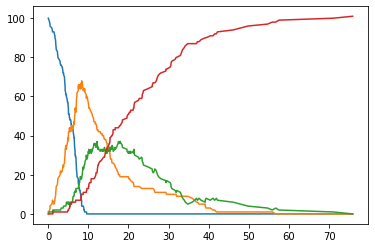

In [4]:
stoch = realise(y0, p0)
plt.plot(stoch['t'], stoch['y'])

In [5]:
realisations = [realise(y0, p0) for _ in range(100)]

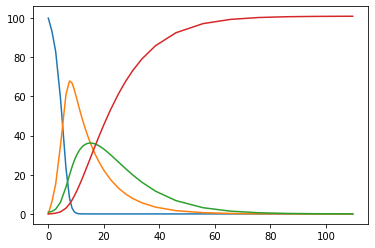

In [6]:
from scipy.integrate import solve_ivp

sol = solve_ivp(lambda t, y: det_model(y, p0), [0, max(r['t'][-1] for r in realisations)], y0, dense_output=True)
plt.plot(sol.t, sol.y.T)

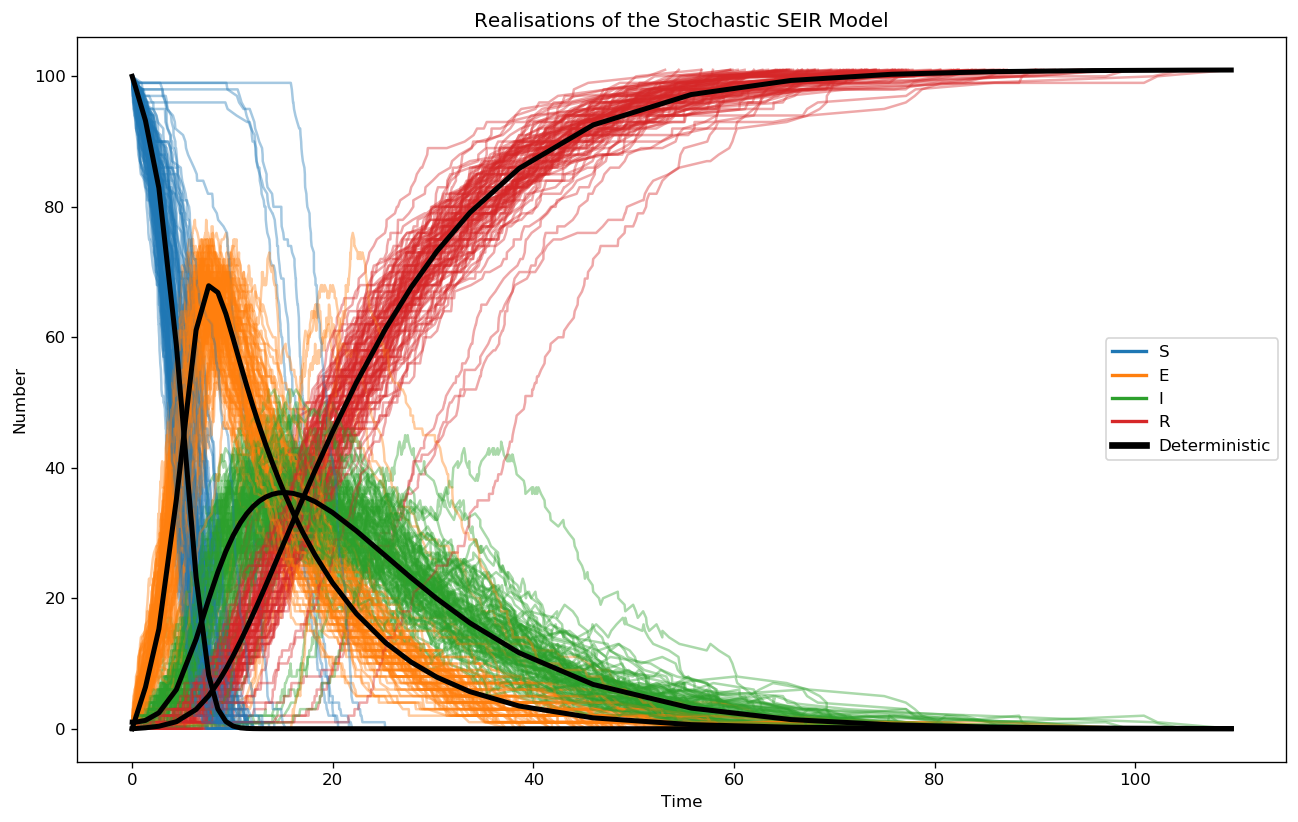

In [7]:
plt.figure(figsize=[13, 8], dpi=120)
dColours = plt.rcParams['axes.prop_cycle'].by_key()['color']
for realisation in realisations:
    plt.plot(realisation['t'], [k[0] for k in realisation['y']], dColours[0], alpha=0.4, label='S')
    plt.plot(realisation['t'], [k[1] for k in realisation['y']], dColours[1], alpha=0.4, label='E')
    plt.plot(realisation['t'], [k[2] for k in realisation['y']], dColours[2], alpha=0.4, label='I')
    plt.plot(realisation['t'], [k[3] for k in realisation['y']], dColours[3], alpha=0.4, label='R')
plt.plot(sol.t, sol.y.T, 'k', linewidth=3);

plt.title('Realisations of the Stochastic SEIR Model')
plt.xlabel('Time')
plt.ylabel('Number')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=dColours[0], lw=2),
                Line2D([0], [0], color=dColours[1], lw=2),
                Line2D([0], [0], color=dColours[2], lw=2),
                Line2D([0], [0], color=dColours[3], lw=2),
                Line2D([0], [0], color='k', lw=4)]
plt.legend(custom_lines, ['S', 'E', 'I', 'R', 'Deterministic'])

In [8]:
dydt = np.abs(np.array([det_model(state, p0) for state in sol.y.T]))

In [9]:
discr = []
for t in np.linspace(0, 100, 101):
    expect = sol.sol(t)[-1]
    tscore = []
    for realisation in realisations:
        tscore.append(np.interp(t, realisation['t'], [r[-1] for r in realisation['y']]))
    discr.append(np.mean(np.abs(np.array(tscore)-expect)))

Text(0, 0.5, '$\\mu_{|R_{stoch}-R_{determ}|}$')

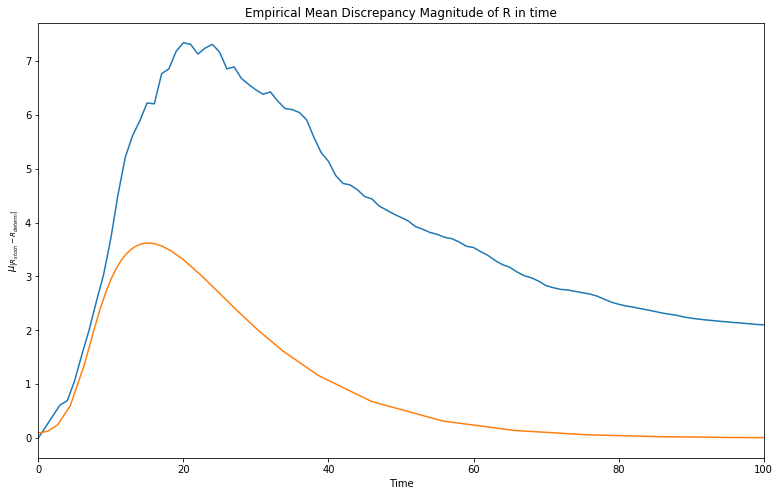

In [10]:
plt.figure(figsize=[13,8])
plt.plot(discr)
plt.plot(sol.t, dydt[:,-1])
plt.xlim([0,100])
plt.title('Empirical Mean Discrepancy Magnitude of R in time')
plt.xlabel('Time')
plt.ylabel(r'$\mu_{|R_{stoch}-R_{determ}|}$')

In [11]:
idiscr = []
for t in np.linspace(0, 100, 101):
    expect = sol.sol(t)[2]
    tscore = []
    for realisation in realisations:
        tscore.append(np.interp(t, realisation['t'], [r[2] for r in realisation['y']]))
    idiscr.append(np.mean(np.abs(np.array(tscore)-expect)))

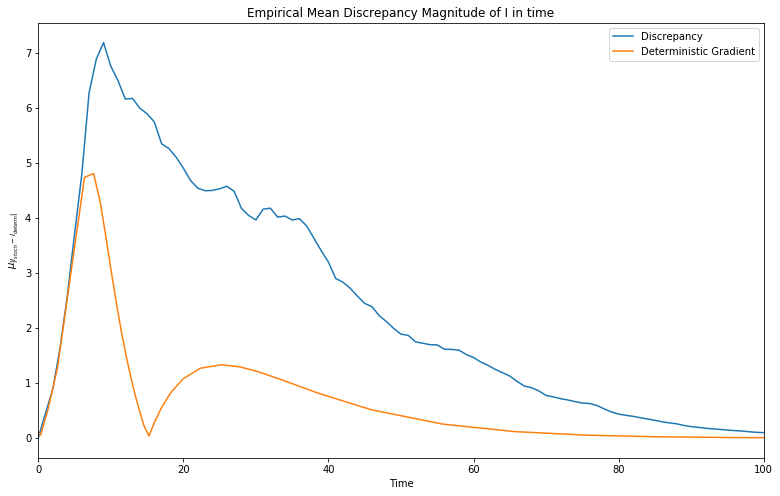

In [12]:
plt.figure(figsize=[13,8])
plt.plot(idiscr)
plt.plot(sol.t, dydt[:,2])
plt.xlim([0,100])
plt.title('Empirical Mean Discrepancy Magnitude of I in time')
plt.xlabel('Time')
plt.ylabel(r'$\mu_{|I_{stoch}-I_{determ}|}$')
plt.legend(['Discrepancy', 'Deterministic Gradient'])

In [13]:
ediscr = []
for t in np.linspace(0, 100, 101):
    expect = sol.sol(t)[1]
    tscore = []
    for realisation in realisations:
        tscore.append(np.interp(t, realisation['t'], [r[1] for r in realisation['y']]))
    ediscr.append(np.mean(np.abs(np.array(tscore)-expect)))

Text(0, 0.5, '$\\mu_{|E_{stoch}-E_{determ}|}$')

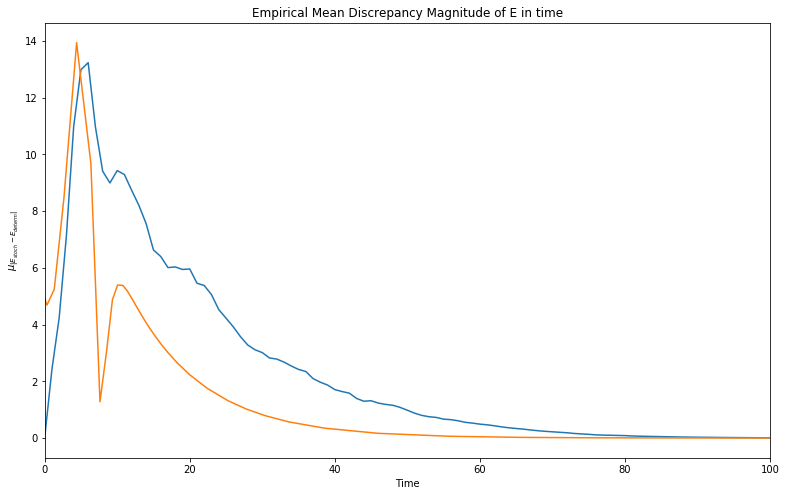

In [14]:
plt.figure(figsize=[13,8])
plt.plot(ediscr)
plt.plot(sol.t, dydt[:,1])
plt.xlim([0,100])
plt.title('Empirical Mean Discrepancy Magnitude of E in time')
plt.xlabel('Time')
plt.ylabel(r'$\mu_{|E_{stoch}-E_{determ}|}$')

In [15]:
sdiscr = []
for t in np.linspace(0, 100, 101):
    expect = sol.sol(t)[0]
    tscore = []
    for realisation in realisations:
        tscore.append(np.interp(t, realisation['t'], [r[0] for r in realisation['y']]))
    sdiscr.append(np.mean(np.abs(np.array(tscore)-expect)))

Text(0, 0.5, '$\\mu_{|S_{stoch}-S_{determ}|}$')

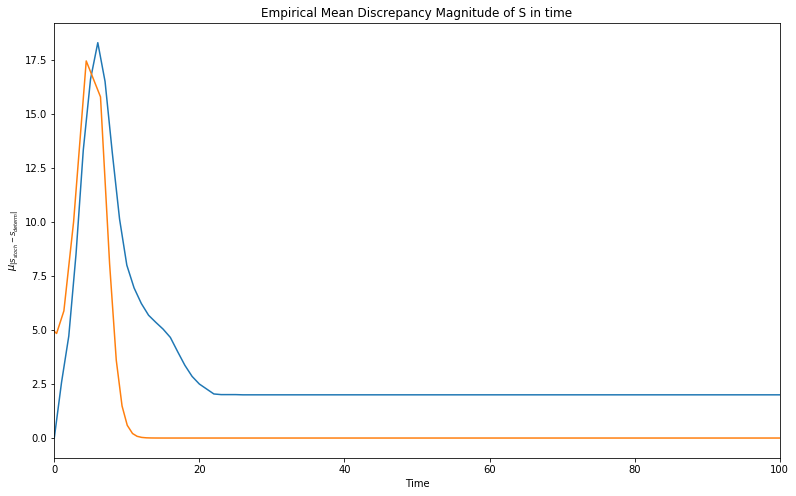

In [16]:
plt.figure(figsize=[13,8])
plt.plot(sdiscr)
plt.plot(sol.t, dydt[:,0])
plt.xlim([0,100])
plt.title('Empirical Mean Discrepancy Magnitude of S in time')
plt.xlabel('Time')
plt.ylabel(r'$\mu_{|S_{stoch}-S_{determ}|}$')

In [17]:
import fitter, modeller
import casadi as ca


In [18]:
def mod_model(t, state, p):
    b, g, a = p
    s, e, i, r, c = state
    n = s+e+i+r
    return [
        -b*s*i/n,
        b*s*i/n - g*e,
        g*e - a*i,
        a*i,
        g*e
    ]

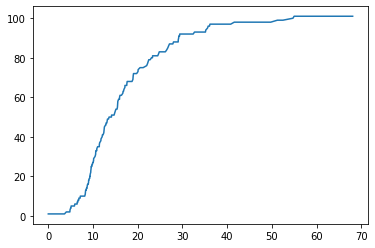

In [27]:
# choose realisation
data = np.random.choice(realisations)
data_y = np.array(data['y'])
# compute cumulative entries into I
I = data_y[:,2]
eI = [1 if I[i]-I[i-1] > 0 else 0 for i in range(1,len(I))]
eI.insert(0, I[0])
cI = np.cumsum(eI)
plt.plot(data['t'], cI)

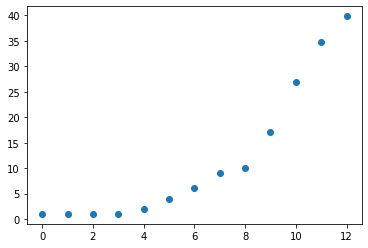

In [59]:
data_time = np.linspace(0, 12, 13)
data_pd = np.array([[i] for i in np.interp(data_time, data['t'], cI)])
plt.plot(data_time, data_pd, 'o')

In [66]:
model_form= {
        "state": 5,
        "parameters": 3
    }
p0guess = [1.5, 1e-6, 1e-6]
config = {
    "grid_size": 200,
    "basis_number": 40,
    "model_form": model_form,
    "time_span": [data_time[0], data['t'][-1]],
    "knot_function": None,
    "model": mod_model,
    "dataset": {"y": data_pd, "t": data_time},
    "observation_vector": [-1],
    "weightings":[
        [1]*model_form['state'],
        np.sqrt((data_time+1)/np.mean(data_time+1))
    ],
    "regularisation_value": copy.copy(p0guess),
}

In [67]:
model = modeller.Model(config)
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 50,
        
    }
}
solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [68]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)


In [103]:
c0 = [100*np.ones(config['basis_number']) for _ in range(model_form['state'])]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*model_form['state']) + [0]*len(config['regularisation_value'])
alpha = 1e0

In [104]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     3790
Number of nonzeros in Lagrangian Hessian.............:     3131

Total number of variables............................:      203
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1000
        inequality constraints with only lower bounds:     1000
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6

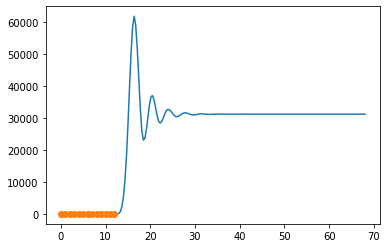

In [105]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs[-1])
plt.plot(data_time, data_pd, 'o')

In [106]:
prange = np.logspace(-5, 5, num=80)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': 0,
        'ubg': 1000,
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-05
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     3790
Number of nonzeros in Lagrangian Hessian.............:     3131

Total number of variables............................:      203
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1000
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1000
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du


Number of Iterations....: 48

                                   (scaled)                 (unscaled)
Objective...............:  1.2298946415098908e-001   1.2298946415098908e-001
Dual infeasibility......:  1.6771342027313327e-009   1.6771342027313327e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5094208388148800e-009   2.5094208388148800e-009
Overall NLP error.......:  2.5094208388148800e-009   2.5094208388148800e-009


Number of objective function evaluations             = 51
Number of objective gradient evaluations             = 49
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 51
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 49
Number of Lagrangian Hessian evaluations             = 48
Total CPU secs in IPOPT (w/o function evaluations)   =      0.252
Total CPU secs in NLP function evaluation


Number of Iterations....: 42

                                   (scaled)                 (unscaled)
Objective...............:  1.2654912387992742e-001   1.2654912387992742e-001
Dual infeasibility......:  1.8610789396123623e-010   1.8610789396123623e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5068974679436400e-009   2.5068974679436400e-009
Overall NLP error.......:  2.5068974679436400e-009   2.5068974679436400e-009


Number of objective function evaluations             = 44
Number of objective gradient evaluations             = 43
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 44
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 43
Number of Lagrangian Hessian evaluations             = 42
Total CPU secs in IPOPT (w/o function evaluations)   =      0.191
Total CPU secs in NLP function evaluation

Total number of variables............................:      203
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1000
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1000
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.5741912e-001 0.00e+000 3.51e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
  50 1.3467241e-001 0.00e+000 8.17e-010  -8.6 1.24e-002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 50

                                   (scaled)                 (unscaled)
Objective...............:  1.3467240846326942e-001   1.3467240846326

  50 1.4611786e-001 0.00e+000 1.71e-004  -5.7 3.11e+000    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 62

                                   (scaled)                 (unscaled)
Objective...............:  1.4555926954723419e-001   1.4555926954723419e-001
Dual infeasibility......:  3.2574223626482190e-010   3.2574223626482190e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5071776339931023e-009   2.5071776339931023e-009
Overall NLP error.......:  2.5071776339931023e-009   2.5071776339931023e-009


Number of objective function evaluations             = 69
Number of objective gradient evaluations             = 63
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 69
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 63
Number of Lagrangian Hessian evaluations             = 62
Total CPU secs in IPO


Number of Iterations....: 65

                                   (scaled)                 (unscaled)
Objective...............:  1.6752100965210387e-001   1.6752100965210387e-001
Dual infeasibility......:  9.5554007383305393e-009   9.5554007383305393e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.9664769084834243e-009   2.9664769084834243e-009
Overall NLP error.......:  9.5554007383305393e-009   9.5554007383305393e-009


Number of objective function evaluations             = 69
Number of objective gradient evaluations             = 66
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 69
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 66
Number of Lagrangian Hessian evaluations             = 65
Total CPU secs in IPOPT (w/o function evaluations)   =      0.271
Total CPU secs in NLP function evaluation

  50 2.0150272e-001 0.00e+000 1.26e+000  -5.7 7.02e+001  -9.7 1.00e+000 1.00e+000f  1

Number of Iterations....: 87

                                   (scaled)                 (unscaled)
Objective...............:  1.9448729488765726e-001   1.9448729488765726e-001
Dual infeasibility......:  1.3569905789323489e-010   1.3569905789323489e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5065988016129121e-009   2.5065988016129121e-009
Overall NLP error.......:  2.5065988016129121e-009   2.5065988016129121e-009


Number of objective function evaluations             = 103
Number of objective gradient evaluations             = 88
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 103
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 88
Number of Lagrangian Hessian evaluations             = 87
Total CPU secs in I

  50 2.3367668e-001 0.00e+000 1.97e+000  -5.7 1.05e+002  -9.2 7.64e-001 5.00e-001f  2
 100 2.2231991e-001 0.00e+000 5.37e-007  -8.6 3.06e-002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 101

                                   (scaled)                 (unscaled)
Objective...............:  2.2231990859739129e-001   2.2231990859739129e-001
Dual infeasibility......:  2.6052746575746036e-011   2.6052746575746036e-011
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059238815492934e-009   2.5059238815492934e-009
Overall NLP error.......:  2.5059238815492934e-009   2.5059238815492934e-009


Number of objective function evaluations             = 143
Number of objective gradient evaluations             = 102
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 143
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua

  50 3.2557200e-001 0.00e+000 8.43e+000  -3.8 8.78e+001    -  1.00e+000 5.00e-001f  2
 100 2.5442015e-001 0.00e+000 1.82e+000  -5.7 1.84e+002    -  1.54e-001 2.07e-001f  2
 150 2.5062502e-001 0.00e+000 2.74e-001  -8.6 9.16e-001    -  9.41e-002 3.05e-001f  1

Number of Iterations....: 156

                                   (scaled)                 (unscaled)
Objective...............:  2.5062279129771886e-001   2.5062279129771886e-001
Dual infeasibility......:  2.0701054743001504e-010   2.0701054743001504e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059674255654501e-009   2.5059674255654501e-009
Overall NLP error.......:  2.5059674255654501e-009   2.5059674255654501e-009


Number of objective function evaluations             = 251
Number of objective gradient evaluations             = 157
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 251
Number of equality

  50 4.8631081e-001 0.00e+000 3.87e+000  -3.8 9.06e+001  -9.0 1.00e+000 5.65e-001f  1
 100 3.2013957e-001 0.00e+000 2.06e+000  -5.7 5.19e+000  -7.3 1.00e+000 9.04e-001f  1
 150 3.0452826e-001 0.00e+000 9.44e-003  -5.7 2.02e+000  -8.1 1.00e+000 1.00e+000f  1
 200 3.0369355e-001 0.00e+000 4.05e-001  -8.6 1.74e+001    -  1.00e+000 1.00e+000f  1
 250 3.0207322e-001 0.00e+000 1.23e-001  -8.6 6.39e+000    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 269

                                   (scaled)                 (unscaled)
Objective...............:  3.0161390827919488e-001   3.0161390827919488e-001
Dual infeasibility......:  6.1183568181698991e-011   6.1183568181698991e-011
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059035596800564e-009   2.5059035596800564e-009
Overall NLP error.......:  2.5059035596800564e-009   2.5059035596800564e-009


Number of objective function evaluations             = 467
Number of objective g

 200 4.1546640e-001 0.00e+000 2.04e+000  -5.7 1.04e+001  -9.1 1.00e+000 1.00e+000f  1
 250 3.8989190e-001 0.00e+000 4.97e-002  -5.7 1.50e+000    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 264

                                   (scaled)                 (unscaled)
Objective...............:  3.8929654380229134e-001   3.8929654380229134e-001
Dual infeasibility......:  5.5375530133572326e-009   5.5375530133572326e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.6770742161501188e-010   9.6770742161501188e-010
Overall NLP error.......:  5.5375530133572326e-009   5.5375530133572326e-009


Number of objective function evaluations             = 494
Number of objective gradient evaluations             = 265
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 494
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua

  50 9.5619799e-001 0.00e+000 3.59e+000  -3.8 6.02e+000  -7.7 1.00e+000 1.00e+000f  1
 100 6.7433976e-001 0.00e+000 9.15e+000  -3.8 6.73e+001    -  1.00e+000 5.00e-001f  2
 150 6.5450801e-001 0.00e+000 7.74e-001  -5.7 6.57e+001  -9.2 1.00e+000 2.35e-001f  3
 200 6.3075613e-001 0.00e+000 6.66e+000  -5.7 1.52e+001    -  6.75e-001 1.00e+000f  1

Number of Iterations....: 243

                                   (scaled)                 (unscaled)
Objective...............:  5.3150989834446061e-001   5.3150989834446061e-001
Dual infeasibility......:  1.0379200277021994e-010   1.0379200277021994e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5266398312672342e-009   2.5266398312672342e-009
Overall NLP error.......:  2.5266398312672342e-009   2.5266398312672342e-009


Number of objective function evaluations             = 397
Number of objective gradient evaluations             = 244
Number of equality constraint evaluations       

 100 1.2924377e+000 0.00e+000 2.70e+001  -3.8 2.67e+001  -8.5 1.00e+000 1.00e+000f  1
 150 1.0960866e+000 0.00e+000 8.32e+001  -5.7 4.26e+001  -7.6 8.90e-001 4.88e-001f  2
 200 1.0730041e+000 0.00e+000 1.06e+000  -5.7 5.11e+001  -7.9 1.00e+000 2.50e-001f  3
 250 9.7519442e-001 0.00e+000 7.54e+000  -5.7 1.99e+001    -  2.44e-001 5.00e-001f  2

Number of Iterations....: 282

                                   (scaled)                 (unscaled)
Objective...............:  7.2992270094764800e-001   7.2992270094764800e-001
Dual infeasibility......:  6.2169473154431114e-009   6.2169473154431114e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6674991987926727e-009   2.6674991987926727e-009
Overall NLP error.......:  6.2169473154431114e-009   6.2169473154431114e-009


Number of objective function evaluations             = 460
Number of objective gradient evaluations             = 283
Number of equality constraint evaluations       

  50 2.4768723e+000 0.00e+000 1.17e+002  -3.8 2.45e+002    -  1.00e+000 1.98e-001f  3
 100 2.1922997e+000 0.00e+000 2.85e+001  -3.8 1.07e+001  -6.9 1.00e+000 5.00e-001f  2
 150 1.7801650e+000 0.00e+000 2.25e+001  -3.8 1.50e+001  -7.1 1.00e+000 5.00e-001f  2
 200 1.7125775e+000 0.00e+000 1.07e+001  -5.7 2.50e+002    -  5.29e-001 8.03e-002f  4
 250 1.6657722e+000 0.00e+000 3.49e+000  -5.7 1.08e+001  -7.4 1.00e+000 1.00e+000f  1
 300 1.4060223e+000 0.00e+000 2.69e+001  -5.7 5.54e+000    -  1.00e+000 9.96e-005f  2

Number of Iterations....: 333

                                   (scaled)                 (unscaled)
Objective...............:  9.7257043771286811e-001   9.7257043771286811e-001
Dual infeasibility......:  4.5023528389165378e-009   4.5023528389165378e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6851367721417869e-009   2.6851367721417869e-009
Overall NLP error.......:  4.5023528389165378e-009   4.5023528389165378e-

  50 3.9559795e+000 0.00e+000 4.08e+001  -2.5 6.08e+001    -  1.00e+000 2.50e-001f  3
 100 3.5155140e+000 0.00e+000 1.25e+001  -3.8 4.67e+000  -6.3 1.00e+000 1.00e+000f  1
 150 2.6895442e+000 0.00e+000 2.85e+001  -3.8 5.48e+000  -6.2 1.00e+000 1.00e+000f  1
 200 2.4017831e+000 0.00e+000 6.65e+000  -3.8 9.18e+000  -7.0 1.00e+000 5.00e-001f  2
 250 2.3681552e+000 0.00e+000 9.18e+000  -3.8 4.99e+001    -  1.00e+000 1.25e-001f  4
 300 2.3282093e+000 0.00e+000 2.95e+000  -3.8 2.72e+001    -  1.00e+000 2.50e-001f  3
 350 2.1888937e+000 0.00e+000 1.28e+001  -3.8 1.17e+001  -6.7 1.00e+000 5.00e-001f  2
 400 1.3327211e+000 0.00e+000 1.40e+001  -3.8 1.03e+001  -6.9 1.00e+000 5.00e-001f  2

Number of Iterations....: 441

                                   (scaled)                 (unscaled)
Objective...............:  1.2320704966615965e+000   1.2320704966615965e+000
Dual infeasibility......:  5.9963561981466760e-009   5.9963561981466760e-009
Constraint violation....:  0.0000000000000000e+000   0.

  50 6.3835821e+000 0.00e+000 5.30e+000  -1.7 3.08e+000    -  1.00e+000 1.00e+000f  1
 100 5.6692300e+000 0.00e+000 2.82e+001  -2.5 5.21e+000    -  1.00e+000 1.00e+000f  1
 150 5.1017318e+000 0.00e+000 3.34e+001  -3.8 5.54e+000  -5.9 1.00e+000 1.00e+000f  1
 200 3.5629208e+000 0.00e+000 2.03e+002  -3.8 2.20e+001  -6.2 1.00e+000 5.00e-001f  2
 250 3.0043566e+000 0.00e+000 1.36e+001  -3.8 5.62e+000  -7.0 1.00e+000 1.00e+000f  1
 300 2.9462103e+000 0.00e+000 4.79e+001  -3.8 1.26e+002  -8.3 1.00e+000 2.50e-001f  3
 350 2.8948888e+000 0.00e+000 1.59e+001  -3.8 8.37e+000  -7.2 1.00e+000 5.00e-001f  2
 400 2.8051928e+000 0.00e+000 2.10e+001  -3.8 2.20e+003  -6.5 4.37e-002 2.08e-003f  5
 450 2.5179427e+000 0.00e+000 4.88e+001  -3.8 6.24e+000  -6.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 1.5243278e+000 0.00e+000 4.00e+000  -3.8 4.48e+000    -  1.00e+000 2.50e-001f  3
 550 1.4695752e+000 0.00e+000 1.35e+000  -8.6 1.52e+000    


Number of Iterations....: 638

                                   (scaled)                 (unscaled)
Objective...............:  1.6088444617060318e+000   1.6088444617060318e+000
Dual infeasibility......:  4.8388723583592252e-013   4.8388723583592252e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059035596809977e-009   2.5059035596809977e-009
Overall NLP error.......:  2.5059035596809977e-009   2.5059035596809977e-009


Number of objective function evaluations             = 1288
Number of objective gradient evaluations             = 639
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1288
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 639
Number of Lagrangian Hessian evaluations             = 638
Total CPU secs in IPOPT (w/o function evaluations)   =      5.114
Total CPU secs in NLP function ev

  50 1.3254513e+001 0.00e+000 2.61e+003  -1.0 2.96e+001  -5.0 1.00e+000 1.00e+000f  1
 100 1.0059738e+001 0.00e+000 6.22e+001  -2.5 3.17e+000  -7.1 1.00e+000 1.00e+000f  1
 150 9.2135829e+000 0.00e+000 1.64e+002  -2.5 1.16e+001    -  1.00e+000 5.00e-001f  2
 200 7.4938048e+000 0.00e+000 2.98e+002  -2.5 6.56e+000  -5.8 1.00e+000 1.00e+000f  1
 250 5.1340099e+000 0.00e+000 1.31e+002  -2.5 4.23e+000  -5.1 1.00e+000 1.00e+000f  1
 300 3.9400050e+000 0.00e+000 1.48e+002  -2.5 3.34e+001  -7.3 1.00e+000 2.50e-001f  3
 350 3.7916126e+000 0.00e+000 1.17e+000  -2.5 6.61e-001    -  1.00e+000 1.00e+000f  1
 400 3.5414570e+000 0.00e+000 9.98e+000  -3.8 4.32e+000  -6.9 1.00e+000 1.00e+000f  1
 450 3.5032902e+000 0.00e+000 4.21e+001  -3.8 4.25e+001  -7.2 1.00e+000 6.25e-002f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 3.3877706e+000 0.00e+000 1.56e+000  -3.8 6.24e-001  -4.9 1.00e+000 1.00e+000f  1
 550 3.2283843e+000 0.00e+000 1.30e+001  -3.8 1.97e+000  -5

 300 5.3669541e+000 0.00e+000 5.25e+001  -2.5 2.52e+000  -5.1 1.00e+000 1.00e+000f  1
 350 4.1052864e+000 0.00e+000 8.24e+002  -2.5 1.14e+001  -6.8 1.00e+000 1.00e+000f  1
 400 3.9456847e+000 0.00e+000 3.23e+001  -2.5 9.89e+000    -  1.00e+000 2.50e-001f  3
 450 3.7153630e+000 0.00e+000 2.15e+002  -3.8 1.50e+002  -8.1 1.00e+000 3.12e-002f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 3.6888920e+000 0.00e+000 2.03e+001  -3.8 2.37e+000  -6.7 1.00e+000 1.00e+000f  1
 550 3.6508274e+000 0.00e+000 4.47e+000  -3.8 1.58e+000  -6.1 1.00e+000 1.00e+000f  1
 600 3.5621666e+000 0.00e+000 4.04e+001  -3.8 9.35e+000  -6.5 1.00e+000 2.50e-001f  3
 650 3.4346189e+000 0.00e+000 5.76e-001  -3.8 3.14e-001  -5.1 1.00e+000 1.00e+000f  1
 700 3.2575427e+000 0.00e+000 3.01e+001  -3.8 1.17e+000  -4.9 1.00e+000 1.00e+000f  1
 750 2.8724055e+000 0.00e+000 1.41e+002  -3.8 1.54e+001  -5.1 5.29e-001 1.45e-001f  3
 800 2.2672503e+000 0.00e+000 1.94e+001  -3.8 1.99e+000  -5

 250 1.0795625e+001 0.00e+000 1.88e+003  -2.5 1.34e+001  -5.4 8.06e-001 5.00e-001f  2
 300 8.6205168e+000 0.00e+000 2.27e+002  -2.5 2.97e+000  -5.2 1.00e+000 1.00e+000f  1
 350 5.9957604e+000 0.00e+000 3.87e+002  -2.5 1.25e+003  -5.6 3.20e-002 2.53e-003f  6
 400 4.3577498e+000 0.00e+000 1.47e+001  -2.5 8.90e-001  -4.6 1.00e+000 1.00e+000f  1
 450 4.0794457e+000 0.00e+000 3.66e+001  -2.5 8.44e+000  -6.7 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 3.8918642e+000 0.00e+000 6.27e+002  -3.8 2.61e+001  -6.8 1.00e+000 2.50e-001f  3
 550 3.8555560e+000 0.00e+000 5.17e+001  -3.8 3.11e+000  -7.0 1.00e+000 1.00e+000f  1
 600 3.8393139e+000 0.00e+000 5.38e+001  -3.8 2.66e+000  -6.8 1.00e+000 5.00e-001f  2
 650 3.8232375e+000 0.00e+000 9.83e+001  -3.8 1.53e+001  -6.3 1.00e+000 6.25e-002f  5
 700 3.7993052e+000 0.00e+000 5.55e+000  -3.8 7.78e-001  -5.8 1.00e+000 1.00e+000f  1
 750 3.7370024e+000 0.00e+000 9.48e+001  -3.8 3.12e+000  -4

  50 2.2145317e+001 0.00e+000 6.10e+002  -1.0 5.09e+000  -3.4 1.00e+000 1.00e+000f  1
 100 1.6344243e+001 0.00e+000 1.60e+004  -1.0 1.34e+002    -  1.00e+000 2.11e-001f  3
 150 1.3862086e+001 0.00e+000 4.18e+001  -2.5 2.70e+000  -5.3 1.00e+000 1.00e+000f  1
 200 1.3287484e+001 0.00e+000 2.70e+002  -2.5 5.35e+000  -5.4 1.00e+000 5.00e-001f  2
 250 1.2580327e+001 0.00e+000 7.65e+002  -2.5 5.07e+000  -5.6 1.00e+000 5.00e-001f  2
 300 1.1281352e+001 0.00e+000 9.57e+002  -2.5 7.46e+000  -5.4 1.00e+000 5.00e-001f  2
 350 9.2717523e+000 0.00e+000 2.03e+002  -2.5 7.48e+000  -6.1 1.00e+000 1.00e+000f  1
 400 6.8134858e+000 0.00e+000 3.71e+002  -2.5 2.89e+000  -5.6 1.00e+000 1.00e+000f  1
 450 5.0342441e+000 0.00e+000 1.47e+003  -2.5 1.12e+001  -6.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 4.3366483e+000 0.00e+000 3.15e+001  -2.5 1.50e+000  -5.4 1.00e+000 1.00e+000f  1
 550 4.2269493e+000 0.00e+000 1.01e+002  -2.5 1.23e+001    

1600 2.3449976e+000 0.00e+000 5.52e-004  -3.8 2.38e-003    -  1.00e+000 1.00e+000h  1
1650 2.3158976e+000 0.00e+000 1.06e+000  -5.7 1.60e-001  -6.5 1.00e+000 1.00e+000f  1
1700 2.3141397e+000 0.00e+000 1.14e-006  -8.6 1.15e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 1701

                                   (scaled)                 (unscaled)
Objective...............:  2.3141397248822249e+000   2.3141397248822249e+000
Dual infeasibility......:  8.8208699535164746e-010   8.8208699535164746e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5067566831174860e-009   2.5067566831174860e-009
Overall NLP error.......:  2.5067566831174860e-009   2.5067566831174860e-009


Number of objective function evaluations             = 3559
Number of objective gradient evaluations             = 1702
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 3559
Number of equa

                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1000
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1000
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2.5123138e+000 0.00e+000 1.27e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
  50 3.1500894e+001 0.00e+000 1.72e+002  -1.0 1.24e+000  -2.4 1.00e+000 1.00e+000f  1
 100 1.9276425e+001 0.00e+000 1.20e+004  -1.0 9.74e+000  -4.0 1.00e+000 1.00e+000f  1
 150 1.6242047e+001 0.00e+000 7.98e+002  -1.0 4.33e+000  -5.3 1.00e+000 1.00e+000f  1
 200 1.4735726e+001 0.00e+000 1.96e+003  -2.5 1.65e+001  -5.7 

 700 5.0177059e+000 0.00e+000 4.28e+002  -2.5 3.61e+000  -5.5 1.00e+000 5.00e-001f  2
 750 4.7046753e+000 0.00e+000 4.33e+002  -2.5 4.04e+000  -5.4 1.00e+000 5.00e-001f  2
 800 4.6482864e+000 0.00e+000 3.53e+002  -2.5 2.36e+000  -6.0 1.00e+000 2.50e-001f  3
 850 4.6450800e+000 0.00e+000 9.49e+000  -2.5 3.16e-001  -6.2 1.00e+000 1.00e+000f  1
 900 4.4626617e+000 0.00e+000 3.24e+002  -3.8 1.11e+000  -5.8 1.00e+000 1.00e+000f  1
 950 4.4075234e+000 0.00e+000 1.40e+001  -3.8 2.68e-001  -4.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 4.3684160e+000 0.00e+000 7.64e+001  -3.8 1.38e+000  -6.1 1.00e+000 1.00e+000f  1
1050 4.3396357e+000 0.00e+000 1.01e+002  -3.8 1.11e+000  -5.6 1.00e+000 5.00e-001f  2
1100 4.3164386e+000 0.00e+000 8.62e+001  -3.8 3.32e+000  -6.9 1.00e+000 5.00e-001f  2
1150 4.2993686e+000 0.00e+000 5.43e+001  -3.8 5.23e-001  -5.4 1.00e+000 1.00e+000f  1
1200 4.2848108e+000 0.00e+000 5.38e+001  -3.8 1.98e+000  -6

1450 4.3745790e+000 0.00e+000 3.45e+001  -3.8 9.45e+000  -7.0 1.00e+000 6.25e-002f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500 4.3672208e+000 0.00e+000 2.01e+001  -3.8 3.28e+000  -7.4 1.00e+000 2.50e-001f  3
1550 4.3584917e+000 0.00e+000 7.84e-001  -3.8 3.71e-002  -4.6 1.00e+000 1.00e+000f  1
1600 4.3498349e+000 0.00e+000 1.48e+001  -3.8 4.49e-001  -5.9 1.00e+000 1.00e+000f  1
1650 4.3377621e+000 0.00e+000 1.08e+002  -3.8 1.58e+000  -6.2 1.00e+000 1.00e+000f  1
1700 4.3215105e+000 0.00e+000 2.85e+000  -3.8 2.06e-001  -4.8 1.00e+000 1.00e+000f  1
1750 4.2896659e+000 0.00e+000 5.93e+000  -3.8 2.85e-001  -4.3 1.00e+000 1.00e+000f  1
1800 4.2233772e+000 0.00e+000 8.98e+000  -3.8 3.99e-001  -4.6 1.00e+000 1.00e+000f  1
1850 4.1000569e+000 0.00e+000 4.30e+001  -3.8 8.05e-001  -5.0 1.00e+000 1.00e+000f  1
1900 3.9916393e+000 0.00e+000 1.07e+002  -3.8 8.04e+000  -5.4 1.00e+000 6.25e-002f  5
1950 3.8978975e+000 0.00e+000 1.34e+002  -3.8 5.56e+000  -6

1800 4.4484482e+000 0.00e+000 2.30e+000  -3.8 2.43e-001  -5.1 1.00e+000 1.00e+000f  1
1850 4.4325797e+000 0.00e+000 1.83e+002  -3.8 9.37e-001  -5.5 1.00e+000 1.00e+000f  1
1900 4.4056708e+000 0.00e+000 1.44e+002  -3.8 2.47e+000  -5.9 1.00e+000 1.00e+000f  1
1950 4.3411777e+000 0.00e+000 4.22e+001  -3.8 6.62e-001  -4.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000 4.2233579e+000 0.00e+000 2.44e+001  -3.8 4.77e-001  -3.9 1.00e+000 1.00e+000f  1
2050 4.1104552e+000 0.00e+000 2.23e+001  -3.8 9.25e-001  -5.2 1.00e+000 1.00e+000f  1
2100 4.0130078e+000 0.00e+000 6.90e+000  -3.8 5.82e-001  -5.1 1.00e+000 1.00e+000f  1
2150 3.9239539e+000 0.00e+000 7.22e+001  -3.8 2.36e+000  -5.8 1.00e+000 1.00e+000f  1
2200 3.8177983e+000 0.00e+000 9.17e+001  -3.8 2.23e+000  -5.8 1.00e+000 1.00e+000f  1
2250 3.7442063e+000 0.00e+000 6.63e+001  -3.8 2.78e-001  -4.1 1.00e+000 1.00e+000f  1
2300 3.6888830e+000 0.00e+000 9.31e+000  -3.8 2.50e-001  -5

1950 4.5810848e+000 0.00e+000 3.95e+001  -3.8 7.50e-001  -5.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000 4.5604764e+000 0.00e+000 1.21e+002  -3.8 1.91e+001  -5.8 1.00e+000 3.12e-002f  6
2050 4.5219369e+000 0.00e+000 1.08e+001  -3.8 3.12e-001  -4.4 1.00e+000 1.00e+000f  1
2100 4.4563911e+000 0.00e+000 1.90e+001  -3.8 6.22e-001  -4.8 1.00e+000 1.00e+000f  1
2150 4.3254998e+000 0.00e+000 1.26e+002  -3.8 9.49e-001  -4.3 1.00e+000 1.00e+000f  1
2200 4.1629400e+000 0.00e+000 4.27e+001  -3.8 2.26e+000  -5.5 1.00e+000 5.00e-001f  2
2250 4.0378191e+000 0.00e+000 3.37e+002  -3.8 1.06e+000  -4.5 1.00e+000 2.50e-001f  3
2300 3.9435767e+000 0.00e+000 1.27e+002  -3.8 1.53e+000  -4.3 1.00e+000 2.50e-001f  3
2350 3.8701855e+000 0.00e+000 5.67e+000  -3.8 2.43e-001  -4.9 1.00e+000 1.00e+000f  1
2400 3.8108547e+000 0.00e+000 6.82e+000  -3.8 8.55e-002  -4.1 1.00e+000 1.00e+000f  1
2450 3.7744080e+000 0.00e+000 1.98e+001  -3.8 2.97e-001  -5

2100 4.7450176e+000 0.00e+000 2.24e+001  -3.8 5.57e-001  -4.9 1.00e+000 2.50e-001f  3
2150 4.7238113e+000 0.00e+000 2.78e+000  -3.8 8.30e-002  -4.4 1.00e+000 1.00e+000f  1
2200 4.6960609e+000 0.00e+000 2.42e+001  -3.8 4.55e-001  -4.8 1.00e+000 1.00e+000f  1
2250 4.6641476e+000 0.00e+000 7.30e+002  -3.8 6.26e+000  -6.1 1.00e+000 2.50e-001f  3
2300 4.6012707e+000 0.00e+000 1.77e+001  -3.8 5.51e-001  -4.6 1.00e+000 1.00e+000f  1
2350 4.4618964e+000 0.00e+000 1.32e+002  -3.8 2.24e+000  -5.0 1.00e+000 5.00e-001f  2
2400 4.3091227e+000 0.00e+000 3.46e+002  -3.8 1.94e+000  -4.0 1.00e+000 2.50e-001f  3
2450 4.0860027e+000 0.00e+000 5.88e+002  -3.8 2.75e+002    -  1.00e+000 2.32e-002f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500 4.0032667e+000 0.00e+000 5.51e+000  -3.8 3.16e-001  -5.0 1.00e+000 1.00e+000f  1
2550 3.9550952e+000 0.00e+000 9.52e+000  -3.8 7.95e-002  -3.8 1.00e+000 1.00e+000f  1
2600 3.9181661e+000 0.00e+000 1.70e+001  -3.8 2.03e-001  -5

2150 4.8329440e+000 0.00e+000 1.23e+001  -3.8 2.45e-001  -3.7 1.00e+000 1.00e+000f  1
2200 4.7565423e+000 0.00e+000 6.09e+001  -3.8 1.31e+000  -4.1 1.00e+000 5.00e-001f  2
2250 4.6041407e+000 0.00e+000 4.61e+001  -3.8 3.80e-001  -3.6 1.00e+000 1.00e+000f  1
2300 4.4156108e+000 0.00e+000 2.32e+002  -3.8 9.17e+002    -  4.04e-001 1.37e-002f  5
2350 4.1699875e+000 0.00e+000 3.01e+002  -5.7 2.85e+000  -5.5 1.00e+000 9.92e-002f  1
2400 4.0787565e+000 0.00e+000 4.14e+001  -5.7 9.53e-001  -5.4 1.00e+000 5.00e-001f  2
2450 4.0399009e+000 0.00e+000 2.88e+002  -5.7 4.97e+001    -  1.60e-002 3.12e-002f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500 4.0181152e+000 0.00e+000 6.67e+001  -5.7 3.68e-001  -5.2 1.00e+000 5.00e-001f  2
2550 4.0002498e+000 0.00e+000 1.33e+001  -5.7 7.67e-002  -4.5 1.00e+000 1.00e+000f  1
2600 3.9827580e+000 0.00e+000 5.70e+000  -5.7 7.86e-002  -4.4 1.00e+000 1.00e+000f  1
2650 3.9673893e+000 0.00e+000 2.31e+001  -5.7 4.78e-001  -5

2250 5.8039579e+000 0.00e+000 1.79e+002  -2.5 3.90e-001  -5.7 1.00e+000 1.00e+000f  1
2300 5.7954527e+000 0.00e+000 5.50e+001  -2.5 2.20e-001  -5.4 1.00e+000 1.00e+000f  1
2350 5.7840488e+000 0.00e+000 2.80e+002  -2.5 7.87e+000    -  1.00e+000 6.25e-002f  5
2400 5.7723048e+000 0.00e+000 3.65e+002  -2.5 1.22e+001  -6.1 1.00e+000 3.12e-002f  6
2450 5.7537292e+000 0.00e+000 1.57e+002  -2.5 1.43e+000  -6.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500 5.7361494e+000 0.00e+000 1.07e+003  -2.5 8.89e-001  -5.6 1.00e+000 1.00e+000f  1
2550 5.7111058e+000 0.00e+000 4.40e+002  -2.5 2.08e+000  -5.0 1.00e+000 2.50e-001f  3
2600 5.6908744e+000 0.00e+000 2.10e+002  -2.5 9.83e+000    -  1.00e+000 6.25e-002f  5
2650 5.6761894e+000 0.00e+000 2.42e+001  -2.5 1.22e-001  -4.3 1.00e+000 1.00e+000f  1
2700 5.6669108e+000 0.00e+000 3.81e+002  -2.5 4.70e-001  -5.0 1.00e+000 1.00e+000f  1
2750 5.6675672e+000 0.00e+000 1.29e+002  -2.5 3.03e-001  -5

2250 6.1223501e+000 0.00e+000 6.04e+001  -2.5 2.15e-001  -5.5 1.00e+000 1.00e+000f  1
2300 6.1152093e+000 0.00e+000 1.61e+001  -2.5 1.08e-001  -5.2 1.00e+000 1.00e+000f  1
2350 6.1062775e+000 0.00e+000 1.10e+002  -2.5 7.80e+000    -  1.00e+000 3.12e-002f  6
2400 6.0999039e+000 0.00e+000 1.98e+000  -2.5 3.54e-002  -4.4 1.00e+000 1.00e+000f  1
2450 6.0903582e+000 0.00e+000 4.85e+002  -2.5 5.62e-001  -5.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500 6.0785987e+000 0.00e+000 3.13e+002  -2.5 4.41e-001  -5.2 1.00e+000 1.00e+000f  1
2550 6.0651313e+000 0.00e+000 2.67e+002  -2.5 4.49e-001  -5.3 1.00e+000 1.00e+000f  1
2600 6.0485530e+000 0.00e+000 1.21e+001  -2.5 8.28e-002  -4.2 1.00e+000 1.00e+000f  1
2650 6.0303019e+000 0.00e+000 2.46e+001  -2.5 1.13e-001  -4.0 1.00e+000 1.00e+000f  1
2700 6.0124698e+000 0.00e+000 3.63e+001  -2.5 1.58e-001  -4.3 1.00e+000 1.00e+000f  1
2750 5.9856854e+000 0.00e+000 1.83e+002  -2.5 3.16e-001  -4

2350 6.4592069e+000 0.00e+000 2.96e+002  -2.5 3.38e+000    -  1.00e+000 1.25e-001f  4
2400 6.4539074e+000 0.00e+000 3.34e+000  -2.5 4.51e-002  -4.7 1.00e+000 1.00e+000f  1
2450 6.4466593e+000 0.00e+000 8.12e+002  -2.5 7.51e-001  -6.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500 6.4390275e+000 0.00e+000 4.23e+001  -2.5 1.55e-001  -5.2 1.00e+000 1.00e+000f  1
2550 6.4314292e+000 0.00e+000 2.67e+002  -2.5 2.68e-001  -5.2 1.00e+000 1.00e+000f  1
2600 6.4231562e+000 0.00e+000 1.07e+002  -2.5 2.42e-001  -5.3 1.00e+000 1.00e+000f  1
2650 6.4145080e+000 0.00e+000 2.57e+001  -2.5 1.16e-001  -4.6 1.00e+000 1.00e+000f  1
2700 6.4049552e+000 0.00e+000 1.09e+003  -2.5 6.69e-001  -5.2 1.00e+000 1.00e+000f  1
2750 6.3890815e+000 0.00e+000 3.18e+002  -2.5 2.51e+000  -5.9 1.00e+000 1.25e-001f  4
2800 6.3761125e+000 0.00e+000 1.11e+003  -2.5 1.25e+000  -5.6 1.00e+000 5.00e-001f  2
2850 6.3563709e+000 0.00e+000 1.16e+003  -2.5 1.28e+000  -5

2350 6.2695421e+000 0.00e+000 1.93e+002  -3.8 1.10e+000  -6.8 1.00e+000 1.00e+000f  1
2400 6.2660738e+000 0.00e+000 1.11e+002  -3.8 5.02e+001    -  1.00e+000 1.56e-002f  7
2450 6.2630113e+000 0.00e+000 3.13e+001  -3.8 3.96e-001  -6.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500 6.2600188e+000 0.00e+000 8.69e+001  -3.8 1.23e+000  -6.8 1.00e+000 5.00e-001f  2
2550 6.2562009e+000 0.00e+000 1.47e+002  -3.8 2.57e+001    -  1.00e+000 3.12e-002f  6
2600 6.2525362e+000 0.00e+000 1.27e+001  -3.8 2.25e-001  -6.0 1.00e+000 1.00e+000f  1
2650 6.2489647e+000 0.00e+000 6.43e+000  -3.8 1.49e-001  -5.9 1.00e+000 1.00e+000f  1
2700 6.2444085e+000 0.00e+000 4.42e+001  -3.8 4.00e-001  -5.8 1.00e+000 5.00e-001f  2
2750 6.2402456e+000 0.00e+000 9.13e+001  -3.8 1.08e+004    -  7.49e-003 4.97e-005f  9
2800 6.2346337e+000 0.00e+000 4.89e-001  -3.8 3.51e-002  -5.0 1.00e+000 1.00e+000f  1
2850 6.2286706e+000 0.00e+000 5.23e+000  -3.8 1.23e-001  -5

2350 7.3812528e+000 0.00e+000 4.49e+002  -2.5 6.07e-001  -4.7 1.00e+000 5.00e-001f  2
2400 7.3117875e+000 0.00e+000 9.54e+002  -2.5 1.01e+001    -  1.00e+000 2.50e-001f  3
2450 7.2695332e+000 0.00e+000 1.76e+003  -2.5 1.37e+002    -  1.00e+000 7.81e-003f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500 7.2326496e+000 0.00e+000 1.19e+001  -2.5 8.86e-002  -4.6 1.00e+000 1.00e+000f  1
2550 7.2158771e+000 0.00e+000 5.86e+001  -2.5 1.78e-001  -5.0 1.00e+000 1.00e+000f  1
2600 7.2086688e+000 0.00e+000 5.50e+002  -2.5 5.15e-001  -5.5 1.00e+000 1.00e+000f  1
2650 7.2031497e+000 0.00e+000 1.46e+003  -2.5 3.29e+000    -  1.00e+000 2.50e-001f  3
2700 7.1950227e+000 0.00e+000 1.00e+002  -2.5 1.91e-001  -5.5 1.00e+000 1.00e+000f  1
2750 7.1876173e+000 0.00e+000 5.06e+001  -2.5 1.43e-001  -5.0 1.00e+000 1.00e+000f  1
2800 7.1818753e+000 0.00e+000 1.57e+001  -2.5 7.66e-002  -4.6 1.00e+000 1.00e+000f  1
2850 7.1737514e+000 0.00e+000 2.89e+002  -2.5 3.39e-001  -5

2450 8.5322423e+000 0.00e+000 1.20e+003  -3.8 8.12e-001  -5.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500 8.3934249e+000 0.00e+000 3.74e+001  -3.8 2.23e-001  -4.5 1.00e+000 1.00e+000f  1
2550 8.2408746e+000 0.00e+000 1.03e+003  -3.8 9.58e-001  -4.9 1.00e+000 1.00e+000f  1
2600 8.0725118e+000 0.00e+000 9.77e+002  -3.8 1.81e+000  -5.3 1.00e+000 5.00e-001f  2
2650 7.8637610e+000 0.00e+000 1.89e+003  -3.8 1.29e+001  -4.8 1.00e+000 4.71e-002f  3
2700 7.6632491e+000 0.00e+000 2.83e+002  -3.8 3.63e+000  -5.1 1.00e+000 1.25e-001f  4
2750 7.5177966e+000 0.00e+000 6.37e+002  -3.8 5.68e-001  -4.9 1.00e+000 1.00e+000f  1
2800 7.3971816e+000 0.00e+000 1.41e+001  -3.8 1.26e-001  -4.4 1.00e+000 1.00e+000f  1
2850 7.2944268e+000 0.00e+000 2.03e+002  -3.8 4.43e+000  -5.8 1.00e+000 1.25e-001f  4
2900 7.2246330e+000 0.00e+000 1.12e+003  -3.8 5.43e-001  -5.0 1.00e+000 1.00e+000f  1
2950 7.1599254e+000 0.00e+000 1.72e+002  -3.8 2.07e-001  -4

2650 7.6416513e+000 0.00e+000 5.21e+002  -3.8 5.52e-001  -5.0 1.00e+000 5.00e-001f  2
2700 7.5904202e+000 0.00e+000 3.81e+001  -3.8 8.15e-002  -4.3 1.00e+000 1.00e+000f  1
2750 7.5443476e+000 0.00e+000 3.06e+002  -3.8 4.38e+003    -  4.48e-002 7.31e-004f  8
2800 7.5017630e+000 0.00e+000 5.03e+002  -3.8 4.81e-001  -4.7 1.00e+000 5.00e-001f  2
2850 7.4614809e+000 0.00e+000 5.36e+002  -3.8 5.16e-001  -5.3 1.00e+000 5.00e-001f  2
2900 7.4282271e+000 0.00e+000 3.14e+002  -3.8 2.23e-001  -5.0 1.00e+000 1.00e+000f  1
2950 7.3989698e+000 0.00e+000 1.65e+002  -3.8 2.13e-001  -5.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000 7.3770152e+000 0.00e+000 2.65e+002  -3.8 1.69e-001  -5.2 1.00e+000 1.00e+000f  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:  4.0540828891581500e+000   7.3770151594387627e+000
Dual infeasibility......:  2.6460344517914206e+002

2900 8.2636094e+000 0.00e+000 1.60e+002  -3.8 7.87e+001    -  3.38e-001 3.12e-002f  6
2950 8.2050655e+000 0.00e+000 3.40e+002  -3.8 7.87e+001    -  5.20e-001 3.12e-002f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000 8.1549164e+000 0.00e+000 1.35e+001  -3.8 9.01e-002  -4.9 1.00e+000 1.00e+000f  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:  1.2641635512626710e+000   8.1549163915671929e+000
Dual infeasibility......:  1.3467223918647374e+001   8.6874902360053667e+001
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.5043397065158537e-004   9.7042542627480725e-004
Overall NLP error.......:  1.3467223918647374e+001   8.6874902360053667e+001


Number of objective function evaluations             = 6155
Number of objective gradient evaluations             = 3001
Number of equality constraint evaluations         

2900 9.9185612e+000 0.00e+000 1.81e+002  -3.8 2.35e-001  -4.7 1.00e+000 1.00e+000f  1
2950 9.8919299e+000 0.00e+000 4.32e+001  -3.8 9.58e-002  -4.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000 9.8604876e+000 0.00e+000 3.96e+002  -3.8 1.06e+000  -5.5 1.00e+000 5.00e-001f  2

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:  8.3563789765355470e+000   9.8604876273837281e+000
Dual infeasibility......:  3.9571721980674602e+002   4.6694444577055475e+002
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.5178479276264367e-004   1.7910533680481222e-004
Overall NLP error.......:  3.9571721980674602e+002   4.6694444577055475e+002


Number of objective function evaluations             = 6041
Number of objective gradient evaluations             = 3001
Number of equality constraint evaluations         

In [107]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

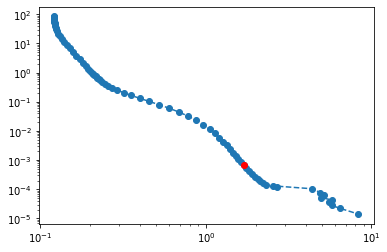

In [108]:
idx = 60
plt.loglog(*fsvals.T, 'o--',)
plt.loglog(*fsvals[idx], 'ro')

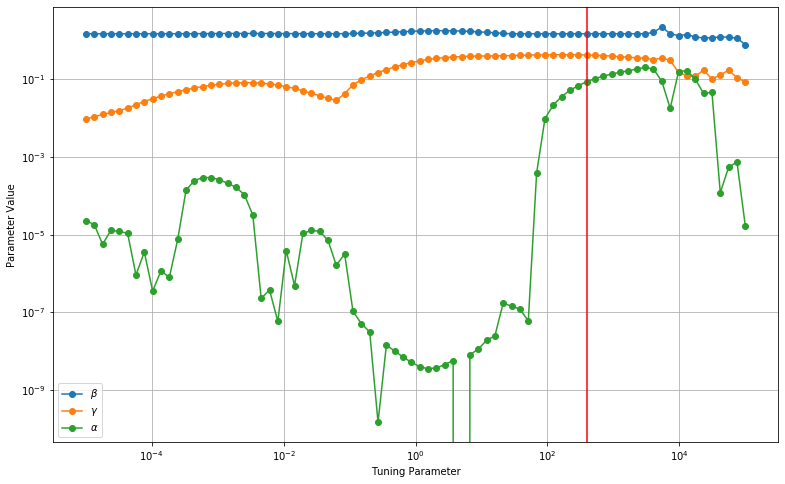

In [109]:
plt.figure(figsize=[13,8])
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\gamma$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\alpha$')
plt.xscale('log')
plt.xlabel('Tuning Parameter')
plt.ylabel('Parameter Value')
plt.yscale('log')
plt.axvline(prange[idx], color='r')
plt.legend()
plt.grid(True)

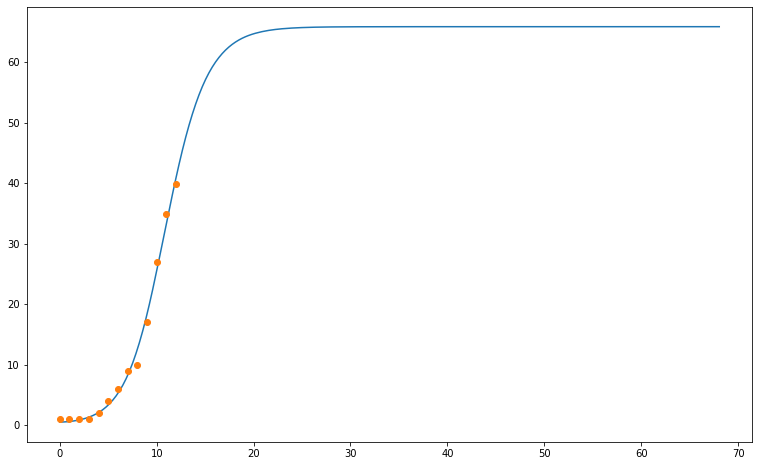

In [110]:
plt.figure(figsize=[13,8])
plt.plot(model.observation_times, getx(sols[idx]['x'])[-1])
plt.plot(data_time, data_pd, 'o')


In [111]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors


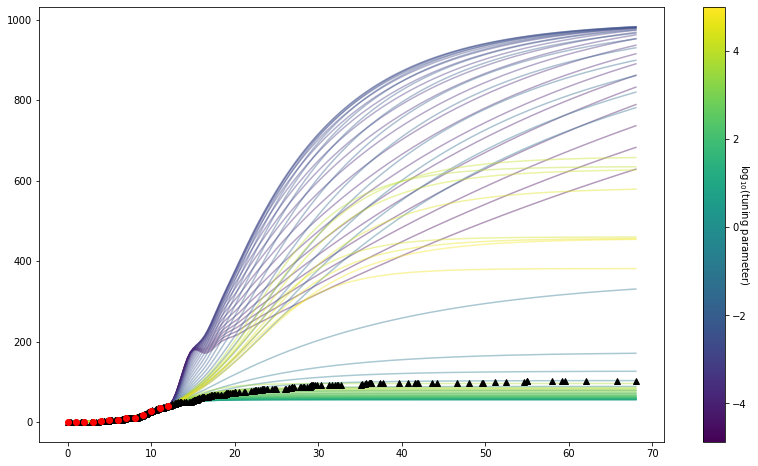

In [112]:

plt.figure(figsize=[14,8])

i0, i1 = (1, -1)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

for i,p in enumerate(prange[i0:i1:]):
    plt.plot(model.observation_times, getx(sols[i+i0]['x'])[-1], 
             color=scalarMap.to_rgba(np.log10(p)), alpha=0.4)
plt.plot(data['t'], cI, 'k^', label="All Data")
plt.plot(data_time, data_pd, 'ro', label='Data')
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)

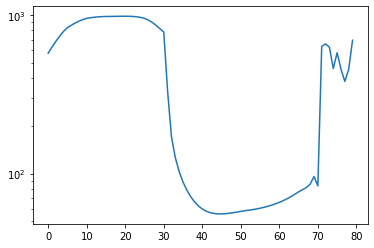

In [113]:
plt.semilogy([getx(sol['x'])[-1][-1] for sol in sols])